# GAN for Anime Faces

The goal of this exercice is to create a DCGAN to generate Manga faces.

## Roadline : 
- Setup the workspace 
  1. Enable the **GPU** (Note: THIS IS NOT NEEDED OUTSIDE OF COLAB ENVS)
  2. Install and import the **Pytorch library**

  
- DCGAN implementation in Pytorch explained 

  0. Import libraries needed 
  1. Load and Prepare dataset
  2. Generator 
  3. Discriminator 
  4. Generator - Discriminator Loss
  5. Optimizer 
  6. Train 


## Setup the workplace 


1. Enable the **GPU** (Note: THIS IS NOT NEEDED OUTSIDE OF COLAB ENVS)


Getting Starting, you need to **enable** the GPU as hardware accelerator : 

             »Edit »Notebook settings »select GPU » SAVE.


and check the GPU type : 

In [ ]:
!nvidia-smi

Sun Oct 24 12:58:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

  2. **install** and **import** the *PyTorch library* 

In [ ]:
#!pip3 install torch torchvision
import torch

## DCGAN implementation in Pytorch

  ### 0. Libraries importation 

For this project, we need to import several packages

In [6]:
import numpy as np
import os
import random
import glob
import time

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.utils as vutils

from PIL import Image
import matplotlib.animation as animation
from IPython.display import HTML
from IPython import display
import matplotlib.pyplot as plt


### 1. Load and Prepare dataset

1) Download the Manga face dataset by cloning the github project of Yaohui Wang 

2) and then unzip the images folder

3) To take a look at the dataset, display the image you want and the associated size

4) Prepare the loaded MangaFace dataset as training set

5) Show the size of the training set 

In [ ]:
# 1) download dataset
!git clone https://gitlab.inria.fr/yaowang/gan_class_images.git

Cloning into 'gan_class_images'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3
Unpacking objects: 100% (3/3), done.


In [ ]:
!ls

gan_class_images  sample_data


In [ ]:
!cd gan_class_images

In [ ]:
# 2) cd images folder and unzip 
!cd gan_class_images;unzip images.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: images/32488.jpg        
  inflating: images/14625.jpg        
  inflating: images/6385.jpg         
  inflating: images/7921.jpg         
  inflating: images/18321.jpg        
  inflating: images/32888.jpg        
  inflating: images/1003.jpg         
  inflating: images/16799.jpg        
  inflating: images/8748.jpg         
  inflating: images/8425.jpg         
  inflating: images/14554.jpg        
  inflating: images/14586.jpg        
  inflating: images/36729.jpg        
  inflating: images/35430.jpg        
  inflating: images/10188.jpg        
  inflating: images/1673.jpg         
  inflating: images/36356.jpg        
  inflating: images/27328.jpg        
  inflating: images/1712.jpg         
  inflating: images/440.jpg          
  inflating: images/30384.jpg        
  inflating: images/27859.jpg        
  inflating: images/28374.jpg        
  inflating: images/14321.jpg        
  inflatin

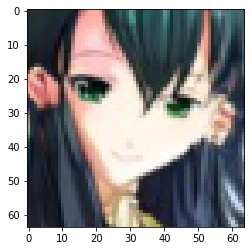

(64, 64, 3)


In [ ]:
# 3) Display one image in the training set and the associated size
# We here chose to display   

# image1 = 34985.jpg 
image1 = plt.imread("gan_class_images/images/841.jpg")
plt.imshow(image1)
plt.show()
print(image1.shape)

# image2 = 240.jpg


In [ ]:
# 4) Prepare the MangaFace Dataset as training set with the help of *class*

class MangaFace(Dataset):
    def __init__(self, root, transform=None):
        """Initialize Mangaface dataset."""
        self.transform = transform
        self.root = root
        self.imgs = glob.glob(self.root + '*')

    def __getitem__(self, idx):
        """Get item from Mangaface class.
        Args:
            index (int): Index
        Returns:
            img: PIL Image.
        """
        img = self.imgs[idx]
        img = Image.open(img).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        """Get length."""
        return len(self.imgs)

In [ ]:
# 5) Show the size of the training set

# normalize all image included on the loaded dataset : 
train_transform = transforms.Compose([
                                      transforms.Resize((64,64)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Define the trainset thanks to MangaFace :
trainset = MangaFace(root='./gan_class_images/images/', transform=train_transform)

# Show the size :
print("Size of the training set : ",len(trainset))

Size of the training set :  36740


### Define Generator and Discriminator networks 

Preliminary work :

1) Define parameters

2) Set device - using GPU

3) Network weights initialization

In [ ]:
# 1) Define parameters 

batch_size = 128  # or other 64, 32 
beta1 = 0.5       # for the optimization function 
lr = 2e-4         # learning rate 
nz = 100          # input dimension 
num_epochs = 100  # trainings 
num_workers = 8

In [ ]:
# 2) Set device - we use GPU 
device = torch.device("cuda:0")

In [ ]:
# 3) Network weights initialization 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)      # N(0,0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)      # N(1,0.02)
        m.bias.data.fill_(0)

### 2. Generator Network


For this project : 

  > input size: batchsize * 100 * 1 * 1

  > output size: batchsize * 3 * 64 * 64


  In oder to generate image from the input noise, we use the operator **ConvTranspose2d** to upsample spatial dimension : 

    nn.ConvTranspose2d(in-channels , out-channels, kernel-size, stride, padding)

1) Define the Generator Network 

2) Test the Generator 


In [ ]:
# Summary of the generator : 
"""
* 1st layer:
transposed convolution
batch norm
relu

* 2nd layer
transposed convolution
batch norm
relu

* 3rd layer
transposed convolution
batch norm
relu

* 4th layer
transposed convolution
batch norm
relu

* 5th layer
transposed convolution
tanh
"""


# 1) Define the Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # TODO:

          # input = bs * 100 * 1 * 1
          # output = bs * 3 * 64 * 64

        # Help of the Sequential module   
        self.net = nn.Sequential(   
        # 1st layer output: bs * 512 * 4 * 4
          nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=True),
          nn.BatchNorm2d(512),
          nn.ReLU(inplace=True),
        # 2nd layer output: bs * 256 * 8 * 8    
          nn.ConvTranspose2d(512, 256, 4, 2, 1),
          nn.BatchNorm2d(256),
          nn.ReLU(inplace=True),
        # 3rd layer output: bs * 128 * 16 * 16
          nn.ConvTranspose2d(256, 128, 4, 2, 1),
          nn.BatchNorm2d(128),
          nn.ReLU(True),
        # 4th layer output: bs * 64 * 32 * 32
          nn.ConvTranspose2d(128, 64, 4, 2, 1),
          nn.BatchNorm2d(64),
          nn.ReLU(True),
        # 5th layer output: bs * 3 * 64 * 64
          nn.ConvTranspose2d(64, 3, 4, 2, 1),
          nn.Tanh()
        )
    def forward(self, x):
      
        out = self.net(x)

        return out

In [ ]:
net = Generator()
print(net)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)


In [ ]:
# 2) Test the Generator
# input : 8 tensor with 100 channels of 1x1 
z = torch.randn(8, 100, 1, 1)

net = Generator()
# output through the Generator "net" : 8 tensor with 3 channels (RGB) of 64x64
out = net(z) # 8 * 3 * 64 * 64

# shape of the out through the Generator ? 
print(out.shape)

torch.Size([8, 3, 64, 64])


### 2. Discriminator Network 

The discriminator take as input a real data or a generated data and perform a binary classification. 

  > input size:  batchsize * 3 * 64 * 64

  > output size: batchsize * 1


1) Define the Discriminator Network 

2) Test the Discriminator 

In [ ]:
# Summary of the discriminator : 
"""
* 1st layer:
convolution
Leakyrelu

* 2nd layer
convolution
batch norm
Leakyrelu

* 3rd layer
convolution
batch norm
Leakyrelu

* 4th layer
convolution
batch norm
Leakyrelu

* 5th layer
convolution
sigmoid
"""


# 1) Define the Discriminator Network

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
        # 1st layer output: bs * 64 * 32 * 32
          nn.Conv2d(3, 64, 4, 2, 1),
          #nn.ReLU(True),
          nn.LeakyReLU(0.2, True),
        # 2nd layer output: bs * 128 * 16 * 16    
          nn.Conv2d(64, 128, 4, 2, 1),
          nn.BatchNorm2d(128),
          nn.LeakyReLU(0.2, True),
        # 3rd layer output: bs * 256 * 8 * 8
          nn.Conv2d(128, 256, 4, 2, 1),
          nn.BatchNorm2d(256),
          nn.LeakyReLU(0.2, True),
        # 4th layer output: bs * 512 * 4 * 4
          nn.Conv2d(256, 512, 4, 2, 1),
          nn.BatchNorm2d(512),
          nn.LeakyReLU(0.2, True),
        # 5th layer output: bs * 1
          nn.Conv2d(512, 1, 4, 1, 0),
          nn.Sigmoid()
        )
    def forward(self, x):

        out = self.net(x)

        return out.squeeze(-1).squeeze(-1)

In [ ]:
# 2) Test the Discriminator
# input : 4 tensor with 3 channels of 64x64 
x = torch.randn(4, 3, 64, 64)

net = Discriminator()
# output through the Discriminator "net" : 
out = net(x) 
print(out.size()) # 4 * 1



torch.Size([4, 1])


### Display Function

In [ ]:
def display_demos(fixed_noise, epoch, iters):
  img_list = []
  with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
    plt.rcParams["figure.figsize"]=10,10
    plt.clf()
    plt.title('epoch: %d iteration: %d'%(epoch, iters))
    imgs = make_grid(fake.data*0.5+0.5).cpu() # CHW
    plt.imshow(imgs.permute(1,2,0).numpy())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1.0)

### Main for G and D

In [ ]:
# define G, D and initialize parameters
# attention: put it into GPU
netG = Generator().to(device)
netD = Discriminator().to(device)
netG.apply(weights_init)
netD.apply(weights_init)


Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

### 4. Generator - Discriminator Loss

In [ ]:
# define loss function 
# hint: binary cross entropy
criterion = nn.BCELoss().to(device)

In [ ]:
#img_list for loss
G_losses = []
D_losses = []
iters = 0

### 5. Optimizer

In [ ]:
# Create batch of latent vectors (64 * nz * 1 * 1) that we will use to visualize
# hint: torch.randn
fixed_noise = torch.randn(64, 100, 1, 1).to(device)

In [ ]:
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### 6. Train

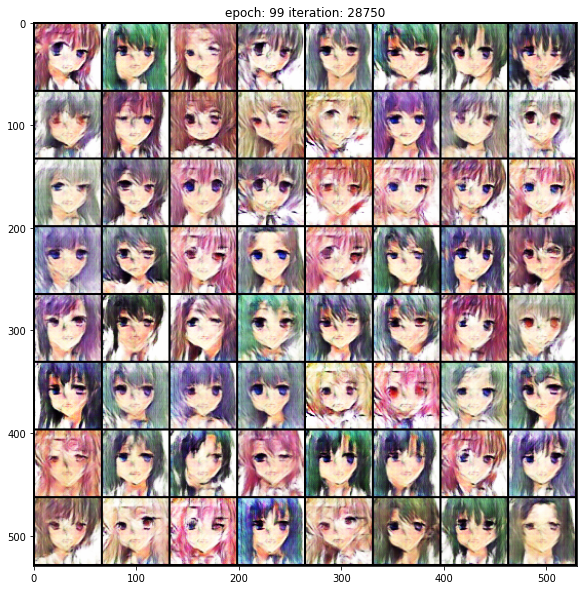

In [ ]:
dataset = MangaFace(root='./gan_class_images/images/', transform=train_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)


print("==> start training")
for epoch in range(num_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(dataloader):
    ############################
    # Update D network
    # maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    # put data into gpu
    real_imgs = data.to(device)

    ## Train with all-real batches
    # set D gradient 0
    netD.zero_grad()

    # Forward pass real batch through D
    output = netD(real_imgs)

    # set ground truth label 1
    label_real = torch.ones(output.size()).to(device)

    # Calculate loss on all-real batch
    errD_real = criterion(output, label_real)

    # Calculate gradients for D in backward pass
    errD_real.backward()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noises = torch.randn(output.size(0), 100, 1, 1).to(device)

    # Generate fake image batch with G
    fake = netG(noises)

    # Classify all fake batch with D
    output = netD(fake.detach())

    # set ground truth label 0
    label_fake = torch.zeros(output.size()).to(device)

    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output, label_fake)

    # Calculate the gradients for this batch
    errD_fake.backward()

    # Add the gradients from the all-real and all-fake batches
    errD = errD_real + errD_fake

    # Update D
    optimizerD.step()

    ############################
    # Update G network
    # maximize log(D(G(z)))
    ###########################
    # set G gradient 0
    netG.zero_grad()

    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = netD(fake)

    # Calculate G's loss based on this output
    errG = criterion(output, label_real)

    # Calculate gradients for G
    errG.backward()

    # Update G
    optimizerG.step()

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # display demo images each 50 iterations
    if iters % 50 == 0:
      display_demos(fixed_noise, epoch, iters)

    iters += 1

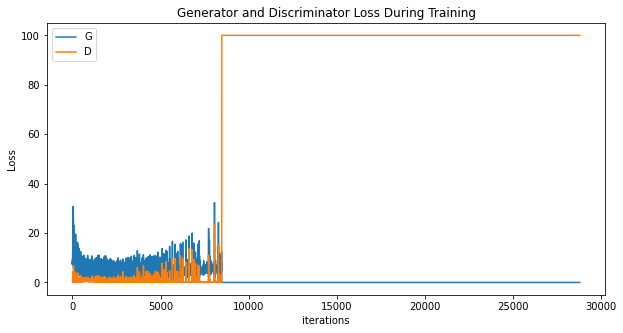

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Report

## 1. Dataset

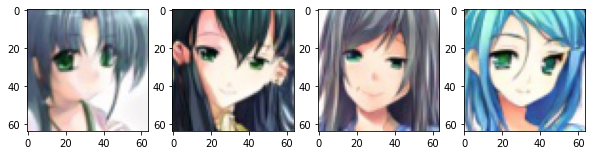

In [ ]:
# Printing four images from the mangaface dataset
for i in range(4):
  img = plt.imread(f"gan_class_images/images/84{i}.jpg")
  plt.subplot(141+i)
  plt.imshow(img)

plt.show()

In [ ]:
# Print the shape of an image from the dataset
img = plt.imread(f"gan_class_images/images/900.jpg")
print(img.shape)

(64, 64, 3)


In [ ]:
# Print the size of the dataset
print(f"Size of the training set : {len(trainset)}")

Size of the training set : 36740


## 2. Networks

- The generator is built with 5 block-filters.

In [ ]:
## Finding the shape of the output of the generator
# random input
z = torch.randn(8, 100, 1, 1)
net = Generator()
out = net(z)


print(out.shape[1:])
# we get the three rgb channels, and the 64x64 pixels

torch.Size([3, 64, 64])


- The discriminator is also built with 5 block-filters.

In [ ]:
## Finding the shape of the output of the discriminator
# random input
x = torch.randn(4, 3, 64, 64)
net = Discriminator()
out = net(x) 
print(out.shape[1:])
# We get a binary output

torch.Size([1])


- The input noise has dimension : $(batchsize) * 100 * 1 * 1$
- For this experiment, the number of epochs was $100$
- The learning rate was set to : $2*10^{-4}$

## 3. Objective - Loss


- The criterion chosen as a loss function is the binary cross entropy.
- Looking at the training losses graph, we can see that at some point during training (around 8000 iterations in our case) the generator reached its goal of perfectly fooling the discriminator (as can be seen from the D loss of 100).


## 4. After training

- See above for the generated images from epoch 99.
- Through each epoch, the input noise gains features from the mangaface images, that get more and more precise with time (the first ones being vague beige patches where the skin is, then rough outlines of the hair, then darker spots for the eyes, etc...)
- It seems that the entropy of generated fake images (G loss) goes to zero, even though it is pretty clear to the eye that they are not real ones.

# Exercises

## Exercise 1

GANs are used in art (for style transfer for example), in cutting-edge medical drug research (most famously in Russia), and in video games to upscale graphics.

## Exercise 2

- The discriminator network is trying to tell real and fake, generated images apart.

- The generator network is trying to generate fake images that fit the real distribution of images well enough to fool the discriminator.

- D is trying to maximise both terms, i.e. to make $D(x)=1$ and $1 - D(G(x)) = 1$, i.e. $D(G(z))=0$. The interpretation of this is that D is trying to make no mistake detecting the real data ($D(x)=1$) as real, and the fake data as fake ($D(G(z)) = 0$).


- G is trying to minimize the second term, i.e. to make $D(G(z))=1$. The interpretation of this is that G is trying to make the discriminator believe that all fake data was in fact from the real distribution.

- The equality shown entails that the discriminator is as good when it comes to detecting real data as when it comes to detecting fake data. It technically means that our fake data is indistinguishable (at least using $D$) from real data (since both get rejected as often by the discriminator).


## Exercise 3

In [7]:
def numParams1Conv(in_channels:int, out_channels:int, kernel_size:int) -> int:
  """Computes the number of parameters of a convolution layer"""
  return (1 + in_channels * (kernel_size**2))*out_channels

In [8]:
# In the case of netD (cf. the definition of the Discriminator Class)

print(f"netD has {numParams1Conv(3, 64, 4) + numParams1Conv(64, 128, 4) + numParams1Conv(128, 256, 4) + numParams1Conv(256, 512, 4) + numParams1Conv(512, 1, 4)} learnable parameters")

netD has 2764737 learnable parameters


In [11]:
def outSize1Conv(in_size:int, out_channels:int, kernel_size:int, stride:int, padding:int, in_pixels = False) -> [int, int, int]:
  """Computes the size of the output image of one convolution layer"""
  top = in_size - kernel_size + 2*padding
  O = int(np.floor(top/stride)+1)
  if in_pixels:
    return (out_channels * (O**2))
  return (out_channels, O, O)

In [14]:
print(f"Image size after first layer: {outSize1Conv(28, 128, 3, 2, 1)}")
print(f"Image size after second layer: {outSize1Conv(14, 128, 3, 2, 1)}")
print(f"Image size after third layer: {outSize1Conv(7, 1, 5, 3, 0)}")

Image size after first layer: (128, 14, 14)
Image size after second layer: (128, 7, 7)
Image size after third layer: (1, 1, 1)


In [18]:
np1 = numParams1Conv(1, 128, 3)
np2 = numParams1Conv(128, 128, 3)
np3 = numParams1Conv(128, 1, 5)

print(f"Number of parameters of first layer: {np1}")
print(f"Number of parameters of second layer: {np2}")
print(f"Number of parameters of third layer: {np3}")
print(f"Total number of learnable parameters: {np1 + np2 + np3}")

Number of parameters of first layer: 1280
Number of parameters of second layer: 147584
Number of parameters of third layer: 3201
Total number of learnable parameters: 152065


In [ ]:

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.net = nn.Sequential(
      # 1st layer
      nn.Conv2d(1, 128, 3, 2, 1),
      nn.LeakyReLU(0.2, True),
      # 2nd layer  
      nn.Conv2d(128, 128, 3, 2, 1),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.2, True),
      # 3rd layer
      nn.Conv2d(128, 1, 5, 3, 0),
      nn.Sigmoid()
    )
  def forward(self, x):
    out = self.net(x)
    return out.squeeze(-1).squeeze(-1)

Taking from the definition of the upsampling dimension-convolution, and the animations shown [here](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) we can see that the size of the output of ConvTranspose2d is :
$$
(I-1) * S - 2P + K + 1
$$

We can explain all of those terms.
- $(I-1)S$ : The stride *spreads apart* the original image by a factor of $S$. The $-1$ appears to take into account the "empty" pixels added between the original pixels when doing a transposed convolution with striding.

- $-2P$ : This is just the padding that disappears on both sides when the transposed convolution is computed (similarily to what would happen in a deconvolution).
- $+K+1$ :  A kernel of size $K$ will...?